<a href="https://colab.research.google.com/github/rubyhung0529/Thesis/blob/main/%E6%B7%A1%E6%B0%B4%E6%B2%B3%E6%B5%81%E5%9F%9F_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
import pandas as pd
import numpy as np
import numpy as np
from tqdm import tqdm_notebook as tqdm
pd.options.display.float_format = '{:.4f}'.format#評分分數不要科學記號,到小數點後三位
seed = 7
np.random.seed(seed)
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#!pip install pytorch_ranger

In [3]:
!pip install git+https://github.com/jonbarron/robust_loss_pytorch
import robust_loss_pytorch 

  Cloning https://github.com/jonbarron/robust_loss_pytorch to /tmp/pip-req-build-q0p35bbl
  Running command git clone -q https://github.com/jonbarron/robust_loss_pytorch /tmp/pip-req-build-q0p35bbl
  Created wheel for robust-loss-pytorch: filename=robust_loss_pytorch-0.0.2-cp36-none-any.whl size=172449 sha256=d2fb3aee1914124a3571dff517bf06b93aa475254ac8cd70ffcdb8811b5694e9
  Stored in directory: /tmp/pip-ephem-wheel-cache-t60d6wmm/wheels/00/c7/55/36012ed43c38c1b3761ef99db3296fefac706acc585afcc090
Successfully built robust-loss-pytorch


In [4]:
full = pd.read_csv('/content/drive/My Drive/碩士論文資料/淡水河流域_cleaned(full).csv').sort_values(by='採樣日期')
full = pd.DataFrame(full)
print(full.shape)
full.head()

(2239, 24)


,測站名稱,採樣日期,河川污染指數,氣溫,水溫,酸鹼值,導電度,溶氧(電極法),溶氧飽和度,生化需氧量,化學需氧量,懸浮固體,大腸桿菌群,氨氮,總磷,硝酸鹽氮,鎘,鉛,六價鉻,砷,汞,銅,鋅,錳
998,板新取水口,2005-03-01 01:30:00,2.3000,13.2000,14.1000,8.1000,247.0000,10.0000,97.5000,1.0000,5.5000,54.3000,4200.0000,0.1100,0.0270,0.5400,0.0010,0.0330,0.0060,0.0012,0.0005,0.0050,0.0210,0.1220
921,暖江橋,2005-03-01 01:44:00,1.5000,17.5000,16.4000,6.6000,144.0000,10.8000,109.8000,2.0000,6.6000,42.1000,17000.0000,0.3500,0.0160,0.7600,0.0010,0.0120,0.0060,0.0014,0.0005,0.0050,0.0790,0.0790
1001,三鶯大橋,2005-03-01 02:20:00,2.3000,13.0000,14.9000,8.0000,201.0000,10.0000,99.5000,1.0000,4.8000,58.9000,2200.0000,0.0800,0.0140,0.5200,0.0010,0.0140,0.0040,0.0009,0.0003,0.0050,0.0300,0.1190
924,六合橋,2005-03-01 02:36:00,2.3000,16.5000,15.9000,6.4000,266.0000,10.0000,100.9000,2.3000,11.6000,92.2000,43000.0000,0.3600,0.0190,0.9700,0.0010,0.0170,0.0030,0.0010,0.0013,0.0090,0.0610,0.1390
987,三峽河抽水站(取代醒心橋),2005-03-01 03:10:00,1.0000,12.5000,14.4000,7.5000,113.0000,10.1000,98.9000,1.0000,5.6000,16.6000,2400.0000,0.0800,0.0140,1.1400,0.0010,0.0100,0.0070,0.0013,0.0011,0.0030,0.0290,0.0420


# define X,y

In [5]:
col = full.columns.tolist()
x_col = col[2:12]
y_col = ['大腸桿菌群','氨氮','總磷','砷','錳']
x_col,y_col

(['河川污染指數',
  '氣溫',
  '水溫',
  '酸鹼值',
  '導電度',
  '溶氧(電極法)',
  '溶氧飽和度',
  '生化需氧量',
  '化學需氧量',
  '懸浮固體'],
 ['大腸桿菌群', '氨氮', '總磷', '砷', '錳'])

# scaled

In [6]:
from sklearn.preprocessing import StandardScaler
ss_x = StandardScaler()
ss_y = StandardScaler()
full[x_col] = ss_x.fit_transform(full[x_col])
full[y_col] = ss_y.fit_transform(full[y_col])
full.head()

,測站名稱,採樣日期,河川污染指數,氣溫,水溫,酸鹼值,導電度,溶氧(電極法),溶氧飽和度,生化需氧量,化學需氧量,懸浮固體,大腸桿菌群,氨氮,總磷,硝酸鹽氮,鎘,鉛,六價鉻,砷,汞,銅,鋅,錳
998,板新取水口,2005-03-01 01:30:00,-0.2499,-1.8174,-1.8293,1.3239,-0.2048,1.0956,0.5661,-0.4758,-0.4337,-0.0255,-0.2295,-0.6466,-0.6323,0.5400,0.0010,0.0330,0.0060,-0.0082,0.0005,0.0050,0.0210,0.1103
921,暖江橋,2005-03-01 01:44:00,-0.6494,-1.1234,-1.3416,-2.2729,-0.2246,1.3649,0.9272,-0.2630,-0.3640,-0.0472,-0.2123,-0.5181,-0.6686,0.7600,0.0010,0.0120,0.0060,0.0964,0.0005,0.0050,0.0790,-0.0480
1001,三鶯大橋,2005-03-01 02:20:00,-0.2499,-1.8497,-1.6596,1.0841,-0.2137,1.0956,0.6248,-0.4758,-0.4780,-0.0173,-0.2322,-0.6627,-0.6752,0.5200,0.0010,0.0140,0.0040,-0.1652,0.0003,0.0050,0.0300,0.0992
924,六合橋,2005-03-01 02:36:00,-0.2499,-1.2848,-1.4476,-2.7525,-0.2011,1.0956,0.6659,-0.1992,-0.0473,0.0418,-0.1773,-0.5127,-0.6587,0.9700,0.0010,0.0170,0.0030,-0.1129,0.0013,0.0090,0.0610,0.1729
987,三峽河抽水站(取代醒心橋),2005-03-01 03:10:00,-0.8991,-1.9304,-1.7657,-0.1148,-0.2306,1.1292,0.6072,-0.4758,-0.4273,-0.0925,-0.2319,-0.6627,-0.6752,1.1400,0.0010,0.0100,0.0070,0.0441,0.0011,0.0030,0.0290,-0.1842


# define model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [8]:
class Net(nn.Module):
  def __init__(self,x_size,y_size):
    super().__init__()
    
    # hyperparamters
    self.h_size = 20
    self.num_layers = 1
    self.num_directions = 1
    self.seq_len = 3
    
    # nets
    self.rnn = nn.RNN(x_size,self.h_size,self.num_layers)#input_size,hidden_size,num_layers
    self.lr = nn.Linear(self.h_size*self.seq_len,y_size)#input_size,output_size

  def forward(self,x):
    batch_size,seq_size,input_size = x.shape
    h0 = torch.randn(self.num_layers*self.num_directions,batch_size,self.h_size)
    x = x.reshape(seq_size,batch_size,input_size)#seq_len, batch, input_size
    output,h_n = self.rnn(x,h0)
    output = output.reshape(batch_size,-1)
    output = self.lr(output)
    return output

In [9]:
model = Net(len(x_col+y_col),len(y_col))

# prepare data and forward test

In [10]:
def create_inout_sequences(input_data,t):
  x = []
  y = []
  for i in range(len(input_data)-t):
    x.append(input_data.iloc[i:i+t][x_col+y_col].values)
    y.append(input_data.iloc[[i+t-1]][y_col].values)
  return np.array(x),np.array(y)

x,y = create_inout_sequences(full,t=model.seq_len)

# batch_size,seq_size,feature_size
x.shape,y.shape

((2236, 3, 15), (2236, 1, 5))

In [11]:
X = torch.FloatTensor(x)
Y = torch.FloatTensor(y).reshape(-1,len(y_col))
sp = int(len(X)*0.7)
X_train,X_test = X[:sp,:],X[sp:,:]
Y_train,Y_test = Y[:sp,:],Y[sp:,:]
train = torch.utils.data.TensorDataset(X_train,Y_train)
train_iter = torch.utils.data.DataLoader(train, batch_size=32, shuffle=True)
test = torch.utils.data.TensorDataset(X_test,Y_test)
test_iter = torch.utils.data.DataLoader(test, batch_size=32, shuffle=True)
model(X_test).shape,Y_test.shape

(torch.Size([671, 5]), torch.Size([671, 5]))

In [12]:
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard
writer = SummaryWriter(log_dir='runs')
writer.add_graph(model,X_test)
writer.close()
%tensorboard --logdir runs

/usr/local/lib/python3.6/dist-packages/torch/jit/_trace.py:966: TracerWarning: Trace had nondeterministic nodes. Did you forget call .eval() on your model? Nodes:
	%hx : Float(1:13420, 671:20, 20:1, requires_grad=0, device=cpu) = aten::randn(%25, %26, %27, %28, %29) # <ipython-input-8-6139982eba22>:17:0
This may cause errors in trace checking. To disable trace checking, pass check_trace=False to torch.jit.trace()
  _module_class,
/usr/local/lib/python3.6/dist-packages/torch/jit/_trace.py:966: TracerWarning: Output nr 1. of the traced function does not match the corresponding output of the Python function. Detailed error:
With rtol=1e-05 and atol=1e-05, found 3355 element(s) (out of 3355) whose difference(s) exceeded the margin of error (including 0 nan comparisons). The greatest difference was 1.2629207372665405 (0.6792698502540588 vs. -0.5836508870124817), which occurred at index (80, 0).
  _module_class,


Reusing TensorBoard on port 6006 (pid 382), started 0:17:35 ago. (Use '!kill 382' to kill it.)

<IPython.core.display.Javascript object>

# optimizer and loss_fn

In [13]:
adaptive = robust_loss_pytorch.adaptive.AdaptiveLossFunction(num_dims=Y.shape[1],float_dtype=np.float32,device='cpu')
params = list(model.parameters()) #+ list(adaptive.parameters())
optimizer = torch.optim.Adam(params,lr=0.01)
#loss_fn = lambda y_i,y:torch.mean(adaptive.lossfun((y_i - y)))
loss_fn = lambda y_i,y:((y_i-y)**2).mean()
loss_fn(model(X_test),Y_test)

tensor(0.3389, grad_fn=<MeanBackward0>)

# train loop

In [14]:
def train(net,train_iter,valid_iter,loss_function,optimizer,num_epochs=100):
    train_history = []
    valid_history = []
    best_loss = np.inf
    best_net = None
    
    for epoch in range(num_epochs):
        # train
        net.train()
        train_loss = 0
        t = 0
        for x,y in train_iter:
            loss = loss_function(net(x),y)
            # weight update
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # record loss
            train_loss += loss.item()
            t += 1
        train_history.append(train_loss/t)
        
        # eval
        net.eval()
        valid_loss = 0
        t = 0
        for x,y in valid_iter:
            loss = loss_function(net(x),y)
            # record loss
            valid_loss += loss.item()
            t += 1
        valid_history.append(valid_loss/t)
        
        # print the epoch loss
        print("epochs {} train loss {:.4f} valid loss {:.4f}".format(
            epoch,train_history[-1],valid_history[-1]))
        
        # record best_net
        if valid_history[-1] <= best_loss:
            best_loss = valid_history[-1]
            best_net = net
            print('record net')
    
    # when end all epoch plot history
    plt.plot(np.array(train_history),label='train')
    plt.plot(np.array(valid_history),label='valid')
    plt.title('loss history')
    plt.legend()
    plt.show()
    
    # return best_net
    return best_net

epochs 0 train loss 0.8883 valid loss 0.0953
record net
epochs 1 train loss 0.5708 valid loss 0.0391
record net
epochs 2 train loss 0.4508 valid loss 0.0404
epochs 3 train loss 0.3803 valid loss 0.0312
record net
epochs 4 train loss 0.3565 valid loss 0.0507
epochs 5 train loss 0.3094 valid loss 0.0347
epochs 6 train loss 0.2780 valid loss 0.0404
epochs 7 train loss 0.2425 valid loss 0.0371
epochs 8 train loss 0.2760 valid loss 0.0322
epochs 9 train loss 0.2491 valid loss 0.0314
epochs 10 train loss 0.2310 valid loss 0.0333
epochs 11 train loss 0.2419 valid loss 0.0494
epochs 12 train loss 0.2326 valid loss 0.0357
epochs 13 train loss 0.2103 valid loss 0.0230
record net
epochs 14 train loss 0.2077 valid loss 0.0233
epochs 15 train loss 0.2024 valid loss 0.0617
epochs 16 train loss 0.2538 valid loss 0.0356
epochs 17 train loss 0.2334 valid loss 0.0279
epochs 18 train loss 0.1995 valid loss 0.0207
record net
epochs 19 train loss 0.1700 valid loss 0.0250
epochs 20 train loss 0.1681 valid l

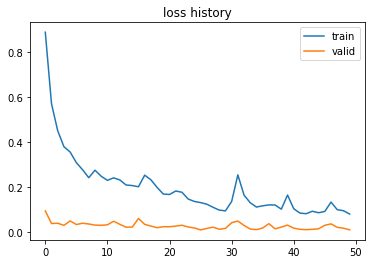

In [15]:
model = train(model,train_iter,test_iter,loss_fn,optimizer,num_epochs=50)

In [16]:
y_pred = model(X_test).detach().cpu().numpy()
y_pred = pd.DataFrame(y_pred,columns=y_col)
y_pred.head()

,大腸桿菌群,氨氮,總磷,砷,錳
0,-0.1188,0.0378,-0.0901,0.2393,0.1696
1,0.0071,-0.6353,-0.6359,-0.4065,-0.2033
2,-0.2332,-0.6670,-0.7317,-0.2172,-0.1457
3,-0.0782,-0.5771,-0.6015,-0.4451,-0.2050
4,-0.2980,-0.7667,-0.7095,-0.3190,-0.3009


In [17]:
y_real = Y_test.detach().cpu().numpy()
y_real = pd.DataFrame(y_real,columns=y_col)
y_real.head()

,大腸桿菌群,氨氮,總磷,砷,錳
0,-0.0200,0.2692,-0.0049,0.1487,0.1250
1,-0.2348,-0.6948,-0.5299,-0.4790,-0.2726
2,-0.2335,-0.6948,-0.6719,-0.2698,-0.2137
3,-0.2257,-0.6948,-0.6818,-0.4267,-0.2689
4,-0.2351,-0.6895,-0.6752,-0.2175,-0.2578


# metric

In [18]:
from sklearn.metrics import r2_score,mean_squared_error

def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [19]:
res = pd.DataFrame(index=y_col,columns=['R2','MSE','MAPE'])

for i in y_col:
    res.loc[i,'R2'] = r2_score(y_real[i],y_pred[i])
    res.loc[i,'MSE'] = mean_squared_error(y_real[i],y_pred[i])
    res.loc[i,'MAPE'] = mape(y_real[i],y_pred[i])
res.loc['AVG'] = res.mean(axis=0)
res

,R2,MSE,MAPE
大腸桿菌群,0.9500,0.0139,61.0230
氨氮,0.9770,0.0122,64.0087
總磷,0.9643,0.0084,59.0066
砷,0.8972,0.0107,55.3959
錳,0.7838,0.0076,157.4739
AVG,0.9145,0.0106,79.3816


In [20]:
for i in adaptive.named_parameters():
  print(i)

('latent_alpha', Parameter containing:
tensor([[2.3842e-07, 2.3842e-07, 2.3842e-07, 2.3842e-07, 2.3842e-07]],
       requires_grad=True))
('latent_scale', Parameter containing:
tensor([[0., 0., 0., 0., 0.]], requires_grad=True))


大腸桿菌群


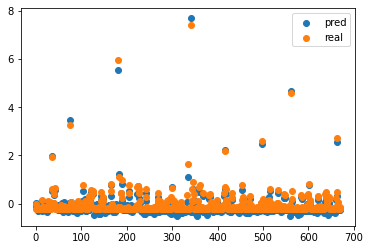

氨氮


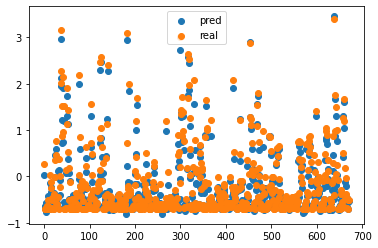

總磷


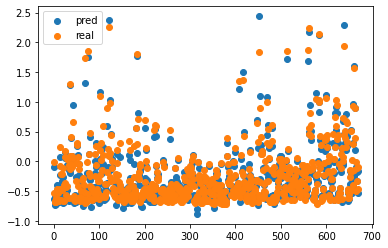

砷


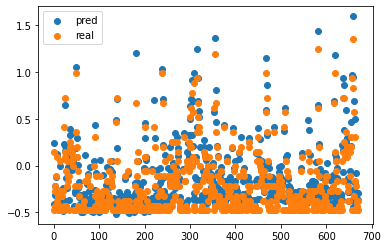

錳


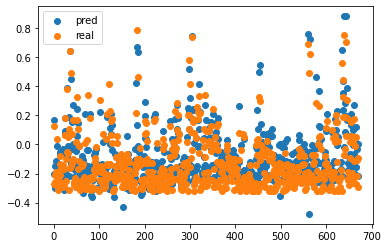

In [21]:
import matplotlib.pyplot as plt
for name in y_pred.columns:
  print(name)
  plt.scatter(y_pred[name].index,y_pred[name],label='pred')
  plt.scatter(y_real[name].index,y_real[name],label='real')
  plt.legend()
  plt.show()